In [1]:
import os
from pathlib import Path
import pandas as pd
import time

from viz import training_progress_static

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
OUTPUTS_DIR = Path('outputs')

In [3]:
!ls outputs

dqn on lander @ 27.04 09.34-0 dqn on lander @ 27.04 09.34-3
dqn on lander @ 27.04 09.34-1 observations
dqn on lander @ 27.04 09.34-2 vanilla dqn, oail params


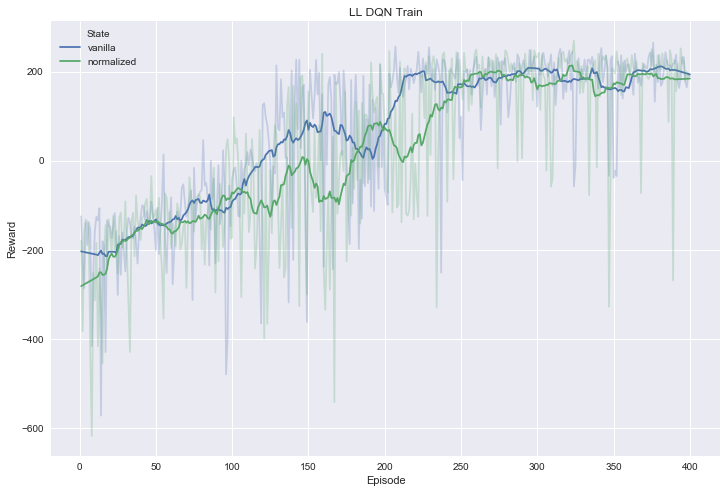

In [11]:
plt.figure(figsize=(12, 8))
training_progress_static([
    pd.read_csv(OUTPUTS_DIR / f'dqn on lander @ 27.04 09.34-3/train.csv'),
    pd.read_csv(OUTPUTS_DIR / f'dqn on lander @ 27.04 11.45-2/train.csv'),
], [20] * 2, ['vanilla', 'normalized'])

plt.title('LL DQN Train')
plt.legend(title='State')
plt.show()

In [ ]:
run_files = [f'lander-{a}-observed-progress.csv' for a in ['vanilla', 'extended', 'dqn', 'dqnp']]
dfs = [pd.read_csv(OUTPUTS_DIR / f) for f in run_files]

# keep best seed
dfs = [df[df.seed == df.groupby('seed').reward.max().sort_values().index[-1]] for df in dfs]

plt.figure(figsize=(10, 6))
training_progress_static(dfs, [10, 10, 10, 5], ['QL', 'QL+', 'DQN', 'DQN+'])
plt.ylim(-700, 50)
plt.title('LunarLander')

for fmt in ['pdf', 'png']:
    plt.savefig(f'figures/lander-comparison.{fmt}', format='png', bbox_inches='tight')
    
plt.show()

In [ ]:
run_files = [f'pole-{a}-observed-progress.csv' for a in ['vanilla', 'extended']]
dfs = [pd.read_csv(OUTPUTS_DIR / f) for f in run_files]

# keep best seed
dfs = [df[df.seed == df.groupby('seed').reward.max().sort_values().index[-1]] for df in dfs]

plt.figure(figsize=(10, 6))
training_progress_static(dfs, [5, 5], ['QL', 'QL+'])
plt.title('CartPole')

for fmt in ['pdf', 'png']:
    plt.savefig(f'figures/pole-comparison.{fmt}', format='png', bbox_inches='tight')
    
plt.show()

---

In [ ]:
run_name = 'lander-extended-observed'

In [ ]:
progress_df = pd.read_csv(OUTPUTS_DIR / (run_name + '-progress.csv'), index_col=0)

In [ ]:
progress_df = progress_df[progress_df.seed.isin([9, 8, 3])]

In [ ]:
plt.figure(figsize=(10, 6))
training_progress_static(progress_df, window_size=15)
plt.ylim(-400, 0)

for fmt in ['pdf', 'png']:
    plt.savefig(f'figures/{run_name}.{fmt}', format='png', bbox_inches='tight')

---

In [ ]:
config_fields = ['env', 'agent', 'state']

In [ ]:
dfs = []

for fname in os.listdir(OUTPUTS_DIR):
    [*config, kind] = fname.split('-')
    if kind != 'runs.csv':
        continue

    df = pd.read_csv(OUTPUTS_DIR / fname, index_col=0)
    for name, value in zip(config_fields, config):
        df[name] = value
    
    dfs.append(df)
    
all_runs = pd.concat(dfs)

In [ ]:
dfs = []

for fname in os.listdir(OUTPUTS_DIR):
    [*config, kind] = fname.split('-')
    if kind != 'progress.csv':
        continue

    df = pd.read_csv(OUTPUTS_DIR / fname, index_col=0)
    for name, value in zip(config_fields, config):
        df[name] = value
    
    dfs.append(df)
    
all_prog = pd.concat(dfs)

In [ ]:
# usual time
all_runs[all_runs.state == 'observed'].pivot_table(
    index='agent',
    columns='env',
    values='time',
    aggfunc='median',
).applymap(lambda s: time.strftime("%H:%M:%S", time.gmtime(s)))

In [ ]:
# most reward
all_prog[all_prog.env == 'lander'].pivot_table(
    index='agent',
    columns='env',
    values='reward',
    aggfunc='max',
)

In [ ]:
# usual convergence
all_prog[all_prog.env == 'pole'].pivot_table(
    index='agent',
    columns='env',
    values='episode',
    aggfunc='median',
)

In [ ]:
all_prog[(all_prog.env == 'lander') & (all_prog.agent == 'vanilla') & (all_prog.episode > 45_000)].groupby('seed').reward.describe()

In [ ]:
all_prog[(all_prog.env == 'lander') & (all_prog.agent == 'extended') & (all_prog.episode > 95_000)].groupby('seed').reward.describe()

---

In [ ]:
def exploration_decay(n_episodes, init, decay, min_val, label=None):
    """ Helps decide exploration parameters by visualizing the decay curve. """
    xs = list(range(n_episodes))
    ys = [init]

    for _ in xs[:-1]:
        # because of floating point errors, compute it iteratively instead of analytically
        ys.append(max(ys[-1] * decay, min_val))

    plt.plot(xs, ys, label=label)

#     plt.ylim(0, 1)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: readable_big_number(x)))
    plt.xlabel('Episode')

In [ ]:
exploration_decay(50_000, .1, .9999, .001)